#Linear Elasticity in 3D

##Introduction

This example provides a demonstration of using PyMKS to compute the linear strain field for a two-phase composite material in 3D, and presents a comparison of the computational efficiency of MKS, when compared with the finite element method. The example first provides information on the boundary conditions, used in MKS. Next, delta microstructures are used to calibrate the first-order influence coefficients. The influence coefficients are then used to compute the strain field for a random microstructure. Lastly, the calibrated influence coefficients are scaled up and are used to compute the strain field for a larger microstructure and compared with results computed using finite element analysis.

###Elastostatics Equations and Boundary Conditions

A review of the governing field equations for elastostatics can be found in the [Linear Elasticity in 2D](elasticity_2D.html) example. The same equations are used in the example with the exception that the second lame parameter (shear modulus) $\mu$ is defined differently in 3D.

$$ \mu = \frac{E}{2(1+\nu)} $$


In general, generating the calibration data for the MKS requires boundary conditions that are both periodic and displaced, which are quite unusual boundary conditions. The ideal boundary conditions are given by:

$$ u(L, y, z) = u(0, y, z) + L\bar{\varepsilon}_{xx} $$
$$ u(0, L, L) = u(0, 0, L) = u(0, L, 0) = u(0, 0, 0) = 0  $$
$$ u(x, 0, z) = u(x, L, z) $$
$$ u(x, y, 0) = u(x, y, L) $$


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import timeit as tm


##Modeling with MKS

###Calibration Data and Delta Microstructures

The first-order MKS influence coefficients are all that is needed to compute a strain field of a random microstructure, as long as the ratio between the elastic moduli (also known as the contrast) is less than 1.5. If this condition is met, we can expect a mean absolute error of 2% or less, when comparing the MKS results with those computed using finite element methods [1]. 

Because we are using distinct phases and the contrast is low enough to only need the first order coefficients, delta microstructures and their strain fields are all that we need to calibrate the first-order influence coefficients [2]. 

The `make_delta_microstructure` function from `pymks.datasets` can be used to create the two delta microstructures needed to calibrate the first-order influence coefficients for a two phase microstructure. This function uses the Python module [SfePy](http://sfepy.org/doc-devel/index.html) to compute the strain fields using finite element methods.

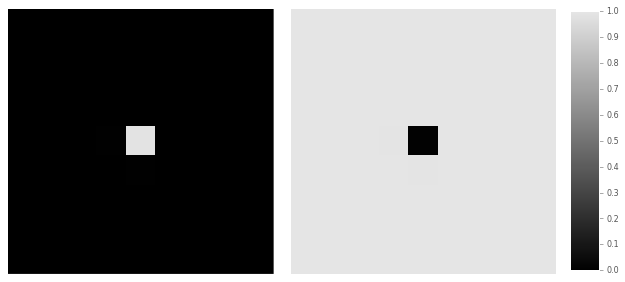

In [2]:
from pymks.tools import draw_microstructures
from pymks.datasets import make_delta_microstructures


n = 9
center = (n - 1) / 2
X_delta = make_delta_microstructures(n_phases=2, size=(n, n, n))
draw_microstructures(X_delta[:, center])


Using delta microstructures for the calibration of the first-order influence coefficients is essentially the same as using a unit [impulse response](http://en.wikipedia.org/wiki/Impulse_response) to find the kernel of a system in signal processing. Delta microstructures are composed of only two phases. One phase is located only at the center cell of the microstructure, and the rest made up of the other phase. 

###Generating Calibration Data

The `make_elasticFEstrain_delta` function from `pymks.datasets` provides an easy interface to generate delta microstructures and their strain fields, which can then be used for calibration of the influence coefficients. The function calls the `ElasticFESimulation` class to compute the strain fields with the boundary conditions given above.

In this example, lets look at a two-phase microstructure with elastic moduli values of 80 and 120 and Poisson's ratio values of 0.3 and 0.3 respectively. Let's also set the macroscopic imposed strain equal to 0.02. All of these parameters used in the simulation must be passed into the `make_elasticFEstrain_delta` function. 

In [3]:
from pymks.datasets import make_elastic_FE_strain_delta
from pymks.tools import draw_microstructure_strain


elastic_modulus = (80, 120)
poissons_ratio = (0.3, 0.3)
macro_strain = 0.02 
size = (n, n, n)

t = tm.time.time()
X_delta, strains_delta = make_elastic_FE_strain_delta(elastic_modulus=elastic_modulus,
                                                      poissons_ratio=poissons_ratio,
                                                      size=size, macro_strain=macro_strain)
print 'Elapsed Time',tm.time.time() - t, 'Seconds'


Elapsed Time 156.211350918 Seconds


Let's take a look at one of the delta microstructures and the $\varepsilon_{xx}$ strain field.

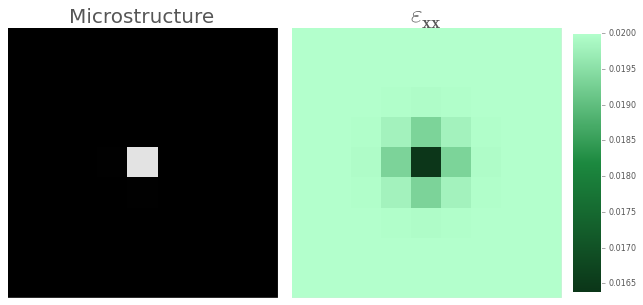

In [4]:
draw_microstructure_strain(X_delta[0, center, :, :], strains_delta[0, center, :, :])


###Calibrating First Order Influence Coefficients

Now that we have the delta microstructures and their strain fields, we can calibrate the influence coefficients by creating an instance of a bases and the `MKSLocalizationModel` class. Because we have 2 discrete phases we will create an instance of the `PrimitiveBasis` with `n_states` equal to 2, and then pass the basis in to create an instance of the `MKSLocalizationModel`. The delta microstructures and their strain fields are then passed to the `fit` method. 

In [5]:
from pymks import MKSLocalizationModel
from pymks.bases import PrimitiveBasis


p_basis = PrimitiveBasis(n_states=2)
model = MKSLocalizationModel(basis=p_basis)


Now, pass the delta microstructures and their strain fields into the `fit` method to calibrate the first order influence coefficients.

In [6]:
model.fit(X_delta, strains_delta)


That's it, the influence coefficient have been calibrated. Let's take a look at them.

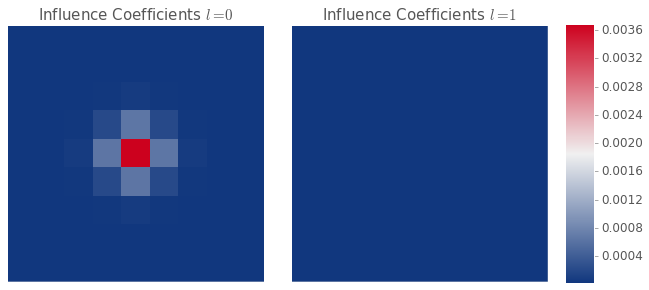

In [7]:
from pymks.tools import draw_coeff


coeff = model.coef_
draw_coeff(coeff[center])


The influence coefficients for $l=0$ have a Gaussian-like shape, while the influence coefficients for $l=1$ are constant-valued. The constant-valued influence coefficients may seem superfluous, but are equally as important. They are equivalent to the constant term in multiple linear regression with [categorical variables](http://en.wikipedia.org/wiki/Dummy_variable_%28statistics%29).

### Predict of the Strain Field for a Random Microstructure

Let's now use our instance of the `MKSLocalizationModel` class with calibrated influence coefficients to compute the strain field for a random two-phase microstructure and compare it with the results from a finite element simulation. 

The `make_elasticFEstrain_random` function from `pymks.datasets` is an easy way to generate a random microstructure and its strain field results from finite element analysis.  

Elapsed Time 78.8157169819 Seconds


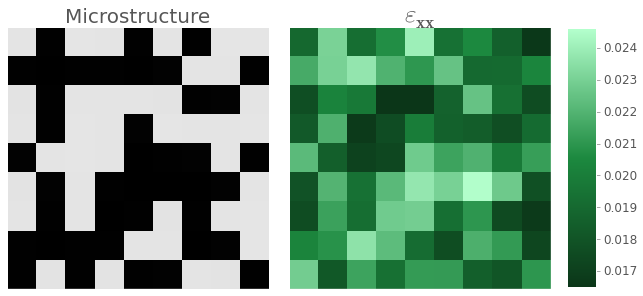

In [8]:
from pymks.datasets import make_elastic_FE_strain_random


np.random.seed(99)
t = tm.time.time()
X, strain = make_elastic_FE_strain_random(n_samples=1, elastic_modulus=elastic_modulus,
                                          poissons_ratio=poissons_ratio, size=size, macro_strain=macro_strain)
print 'Elapsed Time',(tm.time.time() - t), 'Seconds'
draw_microstructure_strain(X[0, center] , strain[0, center])


**Note that the calibrated influence coefficients can only be used to reproduce the simulation with the same boundary conditions that they were calibrated with.**

Now to get the strain field from the `MKSLocalizationModel` just pass the same microstructure to the `predict` method.

In [9]:
t = tm.time.time()
strain_pred = model.predict(X)
print 'Elapsed Time',tm.time.time() - t,'Seconds'


Elapsed Time 0.33176612854 Seconds


Finally let's compare the results from finite element simulation and the MKS model.

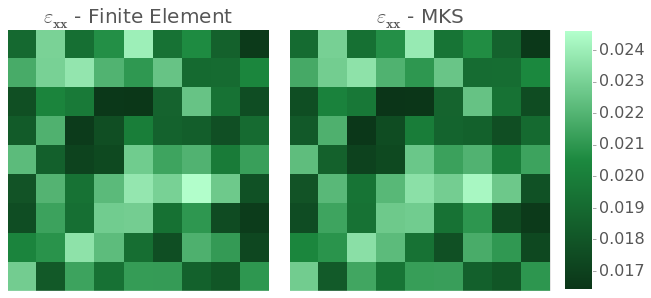

In [10]:
from pymks.tools import draw_strains_compare


draw_strains_compare(strain[0, center], strain_pred[0, center])


Let's look at the difference between the two plots.

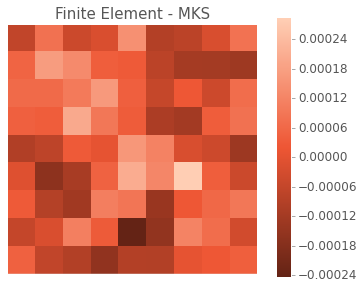

In [11]:
from pymks.tools import draw_differences


draw_differences([strain[0, center] - strain_pred[0, center]], ['Finite Element - MKS'])


The MKS model is able to capture the strain field for the random microstructure after being calibrated with delta microstructures.

##Resizing the Coefficeints to use on Larger Microstructures 

The influence coefficients that were calibrated on a smaller microstructure can be used to predict the strain field on a larger microstructure though spectral interpolation [3], but accuracy of the MKS model drops slightly. To demonstrate how this is done, let's generate a new larger $m$ by $m$ random microstructure and its strain field.

In [12]:
m = 3 * n
center = (m - 1) / 2
t = tm.time.time()
X = np.random.randint(2, size=(1, m, m, m))


The influence coefficients that have already been calibrated need to be resized to match the shape of the new larger microstructure that we want to compute the strain field for. This can be done by passing the shape of the new larger microstructure into the 'resize_coeff' method.

In [13]:
model.resize_coeff(X[0].shape)


Because the coefficients have been resized, they will no longer work for our original $n$ by $n$ sized microstructures they were calibrated on, but they can now be used on the $m$ by $m$ microstructures. Just like before, just pass the microstructure as the argument of the `predict` method to get the strain field.

Elapsed Time 0.0531430244446 Seconds


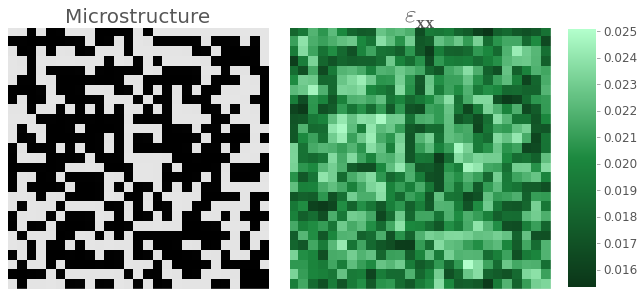

In [14]:
from pymks.tools import draw_strains


t = tm.time.time()
strain_pred = model.predict(X)
print 'Elapsed Time',(tm.time.time() - t), 'Seconds'
draw_microstructure_strain(X[0, center], strain_pred[0, center])



## References

[1] Binci M., Fullwood D., Kalidindi S.R., *A new spectral framework for establishing localization relationships for elastic behav ior of composites and their calibration to finite-element models*. Acta Materialia, 2008. 56 (10): p. 2272-2282 [doi:10.1016/j.actamat.2008.01.017](http://dx.doi.org/10.1016/j.actamat.2008.01.017).


[2] Landi, G., S.R. Niezgoda, S.R. Kalidindi, *Multi-scale modeling of elastic response of three-dimensional voxel-based microstructure datasets using novel DFT-based knowledge systems*. Acta Materialia, 2009. 58 (7): p. 2716-2725 [doi:10.1016/j.actamat.2010.01.007](http://dx.doi.org/10.1016/j.actamat.2010.01.007).


[3] Marko, K., Kalidindi S.R., Fullwood D., *Computationally efficient database and spectral interpolation for fully plastic Taylor-type crystal plasticity calculations of face-centered cubic polycrystals*. International Journal of Plasticity 24 (2008) 1264–1276 [doi;10.1016/j.ijplas.2007.12.002](http://dx.doi.org/10.1016/j.ijplas.2007.12.002).


[4] Marko, K. Al-Harbi H. F. , Kalidindi S.R., *Crystal plasticity simulations using discrete Fourier transforms*. Acta Materialia 57 (2009) 1777–1784 [doi:10.1016/j.actamat.2008.12.017](http://dx.doi.org/10.1016/j.actamat.2008.12.017).